<a href="https://colab.research.google.com/github/khalidpark/machinelearning_whitepaper/blob/main/Machine_learning_whitepaper_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 회귀모델 예시를 사용해 진행하겠습니다.

In [ ]:
import numpy as np
import pandas as pd

# 킹카운티 주택가격 데이터셋을 사용하겠습니다
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/kc_house_data/kc_house_data.csv')

# price, longitude, latitude 양 끝단 값 1% 제거합니다.
# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['long'] >= np.percentile(df['long'], 0.05)) & 
        (df['long'] <= np.percentile(df['long'], 99.95)) &
        (df['lat'] >= np.percentile(df['lat'], 0.05)) & 
        (df['lat'] < np.percentile(df['lat'], 99.95))]

# split train/test, 2015-03-01 기준으로 나눕니다
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
cutoff = pd.to_datetime('2015-03-01')
train = df[df['date'] < cutoff]
test  = df[df['date'] >= cutoff]

In [ ]:
train.shape, test.shape

((16660, 21), (4691, 21))

In [ ]:
train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [ ]:
features = ['bedrooms', 'bathrooms', 'long', 'lat']
target = 'price'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [ ]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=2), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=2
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [ ]:
print('최적 하이퍼파라미터: ', search.best_params_)
print('CV MAE: ', -search.best_score_)
model = search.best_estimator_

최적 하이퍼파라미터:  {'max_depth': 15, 'max_features': 0.6327377306009369, 'n_estimators': 166}
CV MAE:  101224.42224844794


#### 예시로 테스트세트에서 두 번째 샘플의 Shap value를 구해보겠습니다.

In [ ]:
row = X_test.iloc[[1]]  # 중첩 brackets을 사용하면 결과물이 DataFrame입니다
row

,bedrooms,bathrooms,long,lat
9,3,2.5,-122.031,47.3684


In [ ]:
# 실제 집값
y_test.iloc[[1]] # 2번째 데이터를 사용했습니다


9    323000.0
Name: price, dtype: float64

In [ ]:
# 모델 예측값
model.predict(row)


array([341878.50142523])

In [ ]:
# 모델이 이렇게 예측한 이유를 알기 위하여
# SHAP Force Plot을 그려보겠습니다.

import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [ ]:
# 집 가격 평균값을 base value로 합니다.
explainer.expected_value[0]

525264.9249674568

이 관측치의 예측값이 왜 341,878.50 이 나오게 되었는지 각 특성(bathrooms, lat, bedrooms)의 영향을 시각화 하였습니다.

#### 예측함수를 정의합니다.

In [ ]:
def predict(bedrooms, bathrooms, longitude, latitude):

    # 함수 내에서 예측에 사용될 input을 만듭니다
    df = pd.DataFrame(
        data=[[bedrooms, bathrooms, longitude, latitude]], 
        columns=['bedrooms', 'bathrooms', 'long', 'lat']
    )

    # 예측
    pred = model.predict(df)[0]

    # Shap value를 계산합니다
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(df)

    # Shap value, 특성이름, 특성값을 가지는 Series를 만듭니다
    feature_names = df.columns
    feature_values = df.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

    # 결과를 프린트 합니다.
    result = f'평균가격: ${explainer.expected_value[0]:,.0f} \n'
    result += f'예측가격: ${pred:,.0f}. \n'
    result += shaps.to_string()
    print(result)


    # SHAP Force Plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=df
    )

적당한 지역을 관측치로 사용하기 위해 lat의 분포를 보겠습니다.

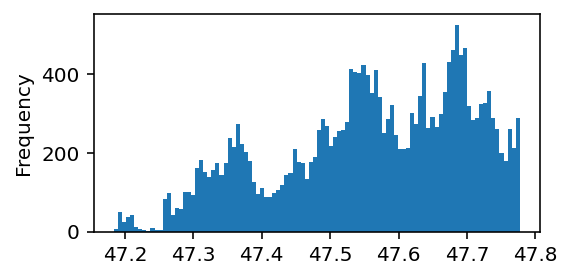

In [ ]:
df['lat'].plot.hist(bins=100, figsize=(4, 2));

#### 적당한 지역에 방 3개 집 가격을 예측해 봅시다.

In [ ]:
predict(3, 1, -121.35, 47.55)

평균가격: $525,265 
예측가격: $382,123. 
(bedrooms, 3.0)     -25124.723574
(bathrooms, 1.0)   -142083.969321
(long, -121.35)     -21022.116137
(lat, 47.55)         45088.940133


#### 같은 지역에 방 2개 집 가격을 예측해 보면, 지역(lat) 수치가 같음에도 영향은 달라짐을 확인할 수 있습니다.

In [ ]:
predict(2, 1, -122.35, 47.55)

평균가격: $525,265 
예측가격: $281,714. 
(bedrooms, 2.0)     -45592.182391
(bathrooms, 1.0)   -118088.150603
(long, -122.35)     -62003.221763
(lat, 47.55)        -17867.074728


#### 같은 지역에 방 1개 집 가격을 예측해 보면

In [ ]:
predict(1, 1, -122.35, 47.55)

평균가격: $525,265 
예측가격: $277,940. 
(bedrooms, 1.0)     -54303.671169
(bathrooms, 1.0)   -120596.652648
(long, -122.35)     -60103.932089
(lat, 47.55)        -12320.268028


#### 여러가지 SHAP plot으로 각 특성이 어떤 값 범위에서 어떤 영향을 주는지 확인할 수 있습니다

In [ ]:
# 100개 테스트 샘플에 대해서 각 특성들의 영향을 봅니다. 샘플 수를 너무 크게 잢으면 계산이 오래걸리니 주의하세요.
shap_values = explainer.shap_values(X_test.iloc[:100])
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[:100])


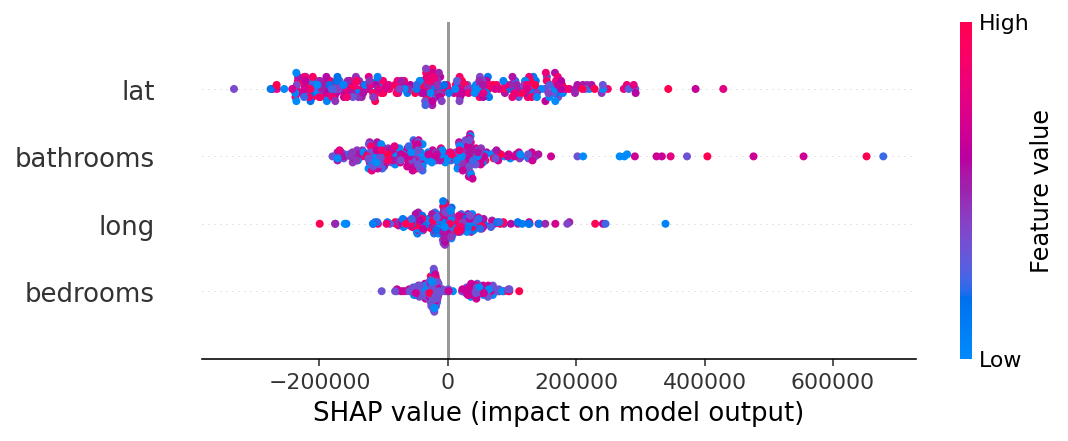

In [ ]:
shap_values = explainer.shap_values(X_test.iloc[:300])
shap.summary_plot(shap_values, X_train.iloc[:300])

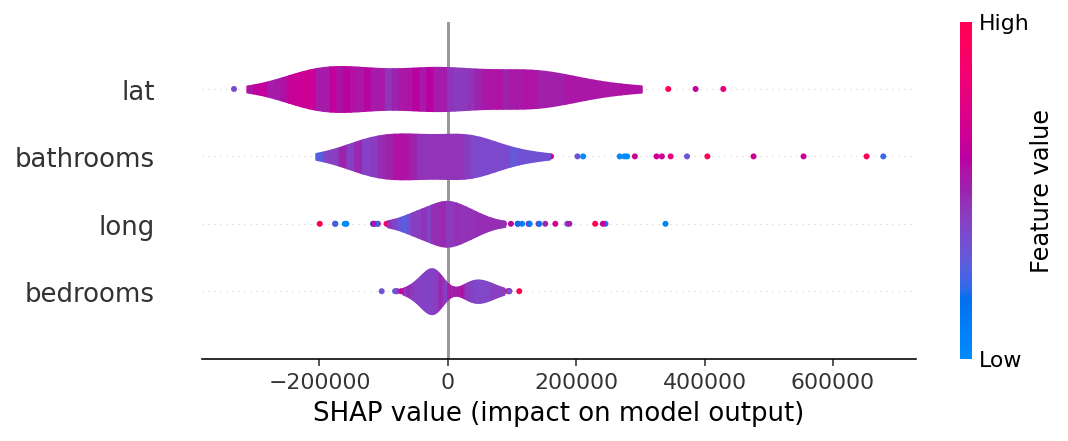

In [ ]:
shap.summary_plot(shap_values, X_train.iloc[:300], plot_type="violin")

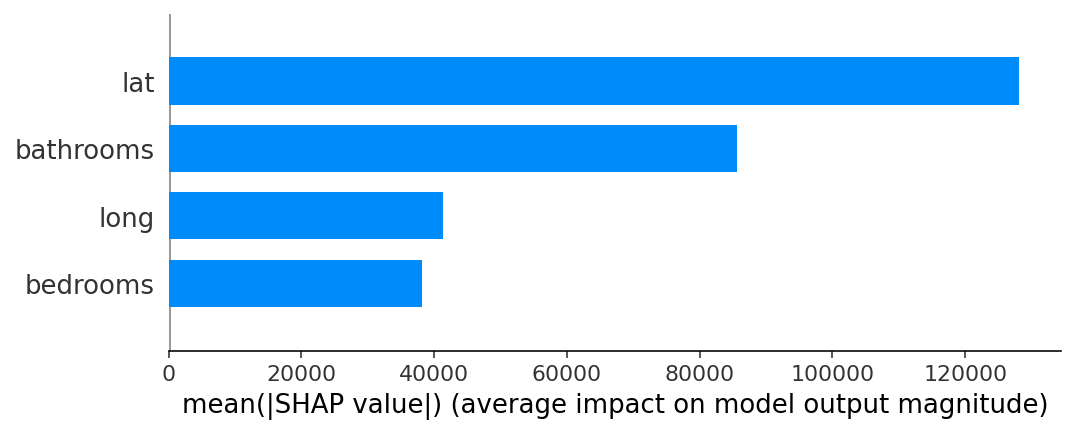

In [ ]:
shap.summary_plot(shap_values, X_train.iloc[:300], plot_type="bar")

### SHAP value를 분류 문제에 적용해 봅시다

이번에는 분류문제를 풀기 위해 Lending Club 데이터를 사용하겠습니다. 대출 상태가 'charged off'(감가상각처리) 인지 'fully paid'(완납) 인지 예측하는 문제 입니다.


In [ ]:
import pandas as pd

# Kaggle 데이터셋에서 10% 샘플링된 데이터입니다.
## Source: https://www.kaggle.com/wordsforthewise/lending-club
## 10% of expired loans (loan_status: ['Fully Paid' and 'Charged Off'])
## grades A-D
## term ' 36 months'
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/lending_club/lending_club_sampled.csv', index_col=0)

In [ ]:
# 2-class 타겟 ('Fully Paid' or 'Charged Off')
target = 'loan_status'
X = df.drop(columns=target)
y = df[target]

In [ ]:
# 데이터셋 분리
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=10000
    , stratify=y
    , random_state=2)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000
    , stratify=y_train_val
    , random_state=42)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (77591, 150)
y_train shape (77591,)
X_val shape (10000, 150)
y_val shape (10000,)
X_test shape (10000, 150)
y_test shape (10000,)


In [ ]:
# test ids를 저장하고 SHAP분석시 사용합니다
test_id = X_test['id']

In [ ]:
def wrangle(X):
    X = X.copy()

    # to datetime
    X['issue_d'] = pd.to_datetime(X['issue_d'], infer_datetime_format=True)
    
    # 개설 날짜 - 최초 신용 개설
    X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True)
    X['earliest_cr_line'] = X['issue_d'] - X['earliest_cr_line']
    X['earliest_cr_line'] = X['earliest_cr_line'].dt.days

    # Engineer issue_d_year
    X['issue_d_year'] = X['issue_d'].dt.year
    
    # Engineer issue_d_year
    X['issue_d_month'] = X['issue_d'].dt.month
            
    # non-digit 문자 치환 -> '', float변환
    X['emp_length'] = X['emp_length'].str.replace(r'\D','').astype(float)
        
    # Get length of free text fields
    X['title'] = X['title'].str.len()
    X['desc'] = X['desc'].str.len()
    X['emp_title'] = X['emp_title'].str.len()
    
    # sub_grade 숫자 치환
    sub_grade_ranks = {'A1': 1.1, 'A2': 1.2, 'A3': 1.3, 'A4': 1.4, 'A5': 1.5, 
                       'B1': 2.1, 'B2': 2.2, 'B3': 2.3, 'B4': 2.4, 'B5': 2.5, 
                       'C1': 3.1, 'C2': 3.2, 'C3': 3.3, 'C4': 3.4, 'C5': 3.5, 
                       'D1': 4.1, 'D2': 4.2, 'D3': 4.3, 'D4': 4.4, 'D5': 4.5}
    X['sub_grade'] = X['sub_grade'].map(sub_grade_ranks)
    
    # 크게 의미 없는 특성 삭제
    X = X.drop(columns='id')        # Always unique
    X = X.drop(columns='url')       # Always unique
    X = X.drop(columns='grade')     # Duplicative of sub_grade
    X = X.drop(columns='zip_code')  # High cardinality
    X = X.drop(columns='issue_d')   # date
    
    # drop null > 70%
    null_frac = X.isnull().mean().sort_values(ascending=False)
    X = X.drop(columns = sorted(list(null_frac[null_frac > 0.7].index)))
    
    # Keep list (https://www.kaggle.com/pileatedperch/predicting-charge-off-from-initial-listing-data)
    # 잠재적인 투자자에게만 제공되는 특성으로만 제한합니다
    keep_list = keep_list = [
        'addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length'
        , 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id'
        , 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status'
        , 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal'
        , 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']
    drop_list = [col for col in X.columns if col not in keep_list]
    X = X.drop(labels=drop_list, axis=1)
        
    # Reset index
    X = X.reset_index(drop=True)
    
    return X

X_train = wrangle(X_train)
X_val   = wrangle(X_val)
X_test  = wrangle(X_test)

print('X_train shape', X_train.shape)
print('X_val shape', X_val.shape)
print('X_test shape', X_test.shape)

X_train shape (77591, 26)
X_val shape (10000, 26)
X_test shape (10000, 26)


In [ ]:
# 클래스의 비율
y_train.value_counts(normalize=True)

Fully Paid     0.847328
Charged Off    0.152672
Name: loan_status, dtype: float64

In [ ]:
ratio = 0.15/0.84
ratio

0.17857142857142858

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

# XGBoost 분류기를 학습시킵니다. 클래스 비율을 맞추기 위해 scale_pos_weight= #Charged Off / # Fully Paid
model = XGBClassifier(n_estimators=1000, verbosity=0, n_jobs=-1, scale_pos_weight=ratio)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.68092	validation_1-auc:0.66370
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.68988	validation_1-auc:0.67363
[2]	validation_0-auc:0.69617	validation_1-auc:0.67690
[3]	validation_0-auc:0.70074	validation_1-auc:0.67876
[4]	validation_0-auc:0.70499	validation_1-auc:0.68039
[5]	validation_0-auc:0.70817	validation_1-auc:0.68202
[6]	validation_0-auc:0.71157	validation_1-auc:0.68287
[7]	validation_0-auc:0.71452	validation_1-auc:0.68418
[8]	validation_0-auc:0.71853	validation_1-auc:0.68446
[9]	validation_0-auc:0.72202	validation_1-auc:0.68474
[10]	validation_0-auc:0.72457	validation_1-auc:0.68577
[11]	validation_0-auc:0.72757	validation_1-auc:0.68632
[12]	validation_0-auc:0.73105	validation_1-auc:0.68667
[13]	validation_0-auc:0.73271	validation_1-auc:0.68708
[14]	validation_0-auc:0.73453	validation_1-auc:0.68692
[15]	validation_0-auc:0.7360

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.17857142857142858,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=0)

In [ ]:
model.classes_

array(['Charged Off', 'Fully Paid'], dtype=object)

In [ ]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
X_val_processed = processor.transform(X_val)
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test AUC for class "{model.classes_[class_index]}":')
print(roc_auc_score(y_test, y_pred_proba)) # 범위는 0-1, 수치는 높을 수록 좋습니다

Test AUC for class "Fully Paid":
0.6839267781606986


In [ ]:
# Confution matrix를 확인해 봅시다
from sklearn.metrics import classification_report
y_test_pred = model.predict(X_test_processed)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

 Charged Off       0.24      0.66      0.35      1527
  Fully Paid       0.91      0.61      0.73      8473

    accuracy                           0.62     10000
   macro avg       0.57      0.64      0.54     10000
weighted avg       0.81      0.62      0.67     10000



#### 예측값 vs 실제값을 비교해 보겠습니다.

In [ ]:
df_p = pd.DataFrame({
    'id': test_id, 
    'pred_proba': y_pred_proba, # 예측확률 
    'status_group': y_test # 실제값
})

df_p = df_p.merge(
     df[['id','issue_d','sub_grade','total_pymnt','funded_amnt', 'term','int_rate']],
     how='left'
)

In [ ]:
df_p.head()

,id,pred_proba,status_group,issue_d,sub_grade,total_pymnt,funded_amnt,term,int_rate
0,57714128,0.678374,Fully Paid,Aug-2015,B1,22351.903560,20000.0,36 months,8.18
1,89784537,0.497685,Charged Off,Sep-2016,C1,7047.420000,10000.0,36 months,12.79
2,127937389,0.826874,Fully Paid,Jan-2018,A3,20462.631376,20000.0,36 months,6.72
3,15169129,0.660449,Fully Paid,May-2014,B4,13832.530000,12000.0,36 months,12.49
4,70844591,0.764140,Fully Paid,Feb-2016,B1,8514.479854,7500.0,36 months,8.39


In [ ]:
fully_paid = df_p['status_group'] == 'Fully Paid'
charged_off = ~fully_paid
right = (fully_paid) == (df_p['pred_proba'] > 0.50)
wrong = ~right

#### 대출은 Fully Paid, 예측이 맞는 경우

In [ ]:
df_p[fully_paid & right].sample(n=10, random_state=1).sort_values(by='pred_proba')

,id,pred_proba,status_group,issue_d,sub_grade,total_pymnt,funded_amnt,term,int_rate
9399,7089584,0.510461,Fully Paid,Oct-2013,B5,34377.488140,28000.0,36 months,13.67
9411,100044078,0.554212,Fully Paid,Mar-2017,B4,2150.308294,2000.0,36 months,11.44
2372,76112758,0.561602,Fully Paid,Apr-2016,B3,6923.419029,6000.0,36 months,9.75
4021,3444793,0.604815,Fully Paid,Mar-2013,B3,21080.855839,17600.0,36 months,12.12
3588,9185826,0.621638,Fully Paid,Dec-2013,B3,17874.050001,15250.0,36 months,11.99
6497,17944230,0.682703,Fully Paid,Jun-2014,B4,17850.691626,15000.0,36 months,11.67
8369,74161780,0.742105,Fully Paid,Mar-2016,B1,25698.317261,24000.0,36 months,8.39
8303,8955677,0.796520,Fully Paid,Nov-2013,A5,9716.443626,8500.0,36 months,8.90
8887,131284906,0.821510,Fully Paid,Apr-2018,A1,10301.429762,10000.0,36 months,5.31
3160,868355,0.898589,Fully Paid,Sep-2011,A1,7600.275447,7000.0,36 months,5.42


In [ ]:
# 테스트셋에서 인덱스 1 샘플의 예측을 살펴보겠습니다.
# 우선 모든 특성 수치를 봅시다
row = X_test.iloc[[3160]]
row

,loan_amnt,term,int_rate,installment,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
3160,7000.0,36 months,5.42,211.12,1.1,10.0,10.0,MORTGAGE,93000.0,Not Verified,...,749.0,16.0,0.0,11435.0,19.4,43.0,f,Individual,NaN,0.0


#### SHAP 그래프로 예측을 설명해 봅시다.

In [ ]:
## UnicodeDecoderError 발생시 xgboost 1.1-> 1.0 다운그레이드 (conda install -c conda-forge xgboost=1.0)
import xgboost
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

#### 예측을 SHAP그래프를 통해 설명하는 함수를 만들어 봅시다

In [ ]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

In [ ]:
pros = shaps.sort_values(ascending=False)[:3].index
cons = shaps.sort_values(ascending=True)[:3].index

In [ ]:
print('fully paid 예측에 대한 Positive 요인 Top 3 입니다:')
for i, pro in enumerate(pros, start=1):
    feature_name, feature_value = pro
    print(f'{i}. {feature_name} : {feature_value}')

print('\n')
print('Negative 요인 Top 3 입니다:')
for i, con in enumerate(cons, start=1):
    feature_name, feature_value = con
    print(f'{i}. {feature_name} : {feature_value}')

fully paid 예측에 대한 Positive 요인 Top 3 입니다:
1. sub_grade : 1.1
2. int_rate : 5.42
3. fico_range_low : 745.0


Negative 요인 Top 3 입니다:
1. open_acc : 16.0
2. purpose : major_purchase
3. addr_state : PA


In [ ]:
def explain(row_number):
    positive_class = 'Fully Paid'
    positive_class_index = 1

    # row 값을 변환합니다
    row = X_test.iloc[[row_number]]
    row_processed = processor.transform(row)

    # 예측하고 예측확률을 얻습니다 
    pred = model.predict(row_processed)[0]
    pred_proba = model.predict_proba(row_processed)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba

    # 예측결과와 확률값을 얻습니다
    print(f'이 대출에 대한 예측결과는 {pred} 으로, 확률은 {pred_proba:.0f}% 입니다.')
    
    # SHAP를 추가합니다
    shap_values = explainer.shap_values(row_processed)

    # Fully Paid에 대한 top 3 pros, cons를 얻습니다
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    # 예측에 가장 영향을 준 top3
    print('\n')
    print('Positive 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # 예측에 가장 반대적인 영향을 준 요인 top1
    print('\n')
    print('Negative 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = cons if pred == positive_class else pros
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # SHAP
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row, 
        link='logit'
    )

In [ ]:
explain(3160)

이 대출에 대한 예측결과는 Fully Paid 으로, 확률은 90% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. sub_grade : 1.1
2. int_rate : 5.42
3. fico_range_low : 745.0


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. open_acc : 16.0
2. purpose : major_purchase
3. addr_state : PA


#### 몇몇 예제를 더 살펴 봅시다

#### 대출결과는 Charged Off, 예측이 성공한 경우

In [ ]:
df_p[charged_off & right].sample(n=10, random_state=1).sort_values(by='pred_proba')

,id,pred_proba,status_group,issue_d,sub_grade,total_pymnt,funded_amnt,term,int_rate
5074,111985653,0.192106,Charged Off,Jul-2017,D2,11787.09,20000.0,36 months,18.06
2978,70823522,0.264359,Charged Off,Feb-2016,C3,10858.62,19200.0,36 months,13.67
2462,41039588,0.307426,Charged Off,Feb-2015,C2,7952.03,14975.0,36 months,12.69
9686,76091925,0.327640,Charged Off,Mar-2016,C1,5618.92,9100.0,36 months,11.99
9131,62924113,0.340124,Charged Off,Oct-2015,C5,2561.30,7200.0,36 months,14.65
7859,95652501,0.402326,Charged Off,Jan-2017,C1,6579.25,16800.0,36 months,12.74
3323,79432195,0.402682,Charged Off,Jun-2016,B5,5199.13,9000.0,36 months,11.47
450,131210900,0.445927,Charged Off,Apr-2018,C2,566.56,5600.0,36 months,13.58
6283,41600295,0.462757,Charged Off,Mar-2015,D4,18207.64,18000.0,36 months,17.57
9824,108111954,0.483546,Charged Off,May-2017,B4,2977.37,8000.0,36 months,10.91


In [ ]:
explain(5074)

이 대출에 대한 예측결과는 Charged Off 으로, 확률은 81% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. sub_grade : 4.2
2. installment : 723.66
3. int_rate : 18.06


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. initial_list_status : f
2. purpose : credit_card
3. pub_rec : 0.0


#### 대출 결과는 Fully Paid, 예측이 잘못된 경우

In [ ]:
df_p[fully_paid & wrong].sample(n=10, random_state=1).sort_values(by='pred_proba')

,id,pred_proba,status_group,issue_d,sub_grade,total_pymnt,funded_amnt,term,int_rate
3559,90406949,0.170803,Fully Paid,Sep-2016,D4,46102.632640,35000.0,36 months,19.99
9661,88133637,0.195758,Fully Paid,Aug-2016,D4,31018.610000,29500.0,36 months,19.99
745,94101950,0.361312,Fully Paid,Dec-2016,B3,7199.261061,6500.0,36 months,11.39
6139,48916798,0.375068,Fully Paid,May-2015,C2,5919.802458,4900.0,36 months,12.69
2860,68843982,0.379977,Fully Paid,Jan-2016,C2,10891.649390,9000.0,36 months,12.88
4118,85749416,0.387950,Fully Paid,Jul-2016,C3,11010.062106,10000.0,36 months,13.99
1650,65977080,0.401841,Fully Paid,Dec-2015,B4,22359.392396,20000.0,36 months,10.64
1738,24625443,0.411734,Fully Paid,Aug-2014,C4,7063.740000,6000.0,36 months,14.49
8372,4085042,0.414754,Fully Paid,Apr-2013,D1,18311.009999,14125.0,36 months,17.77
4498,814604,0.464202,Fully Paid,Aug-2011,B3,6780.836890,6400.0,36 months,10.99


In [ ]:
explain(3559)

이 대출에 대한 예측결과는 Charged Off 으로, 확률은 83% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. sub_grade : 4.4
2. installment : 1300.55
3. int_rate : 19.99


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. home_ownership : MORTGAGE
2. emp_length : 10.0
3. revol_bal : 21434.0


#### 대출 결과는 Charged Off, 예측이 잘못된 경우

In [ ]:
df_p[charged_off & wrong].sample(n=10, random_state=1).sort_values(by='pred_proba')

,id,pred_proba,status_group,issue_d,sub_grade,total_pymnt,funded_amnt,term,int_rate
5788,88109468,0.505276,Charged Off,Aug-2016,B5,4744.09,6000.0,36 months,11.49
4379,1244519,0.526809,Charged Off,Apr-2012,C1,7236.45,10000.0,36 months,13.99
3951,9245255,0.557323,Charged Off,Dec-2013,B5,11736.21,15000.0,36 months,13.67
4462,767790,0.564022,Charged Off,May-2011,C2,13205.74,20000.0,36 months,13.49
1019,57175801,0.589931,Charged Off,Aug-2015,D2,6028.16,24000.0,36 months,16.55
3845,87014268,0.606454,Charged Off,Aug-2016,B5,1254.15,3000.0,36 months,11.49
7154,56200429,0.660765,Charged Off,Aug-2015,B5,9968.60,15000.0,36 months,11.53
3302,8666212,0.689634,Charged Off,Nov-2013,B1,12719.06,16000.0,36 months,9.67
9870,95061765,0.763744,Charged Off,Dec-2016,A5,1194.00,2000.0,36 months,7.99
7896,61352218,0.905772,Charged Off,Oct-2015,A3,2956.38,4000.0,36 months,6.89


In [ ]:
explain(7896)

이 대출에 대한 예측결과는 Fully Paid 으로, 확률은 91% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. sub_grade : 1.3
2. int_rate : 6.89
3. dti : 5.72


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. annual_inc : 31000.0
2. emp_length : 3.0
3. earliest_cr_line : 8705
